In [1]:
import logging
import geopandas as gpd
from sliderule import icesat2
from mpl_toolkits.basemap import Basemap
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import geopandas as gpd
from sliderule import gedi, earthdata, raster

In [2]:
# ## Region 1: South Cascade Glacier
# ## Upper left (lon/lat): -121.0742643433662, 48.37159557493268
# ## Lower right (lon/lat): -121.03683181392472, 48.341195823749906

lon_up = -121.0742643433662
lat_up =  48.37159557493268
lon_lo = -121.03683181392472
lat_lo =  48.341195823749906
region_name='South Cascade Glacier'

## Region 2: Maryland
## Upper left (lon/lat): -77.41454197206069, 39.290044188370636
## Lower right (lon/lat): -77.39562385238138, 39.239373031026304

# lon_up = -77.41454197206069
# lat_up =  39.290044188370636
# lon_lo = -77.39562385238138
# lat_lo =  39.239373031026304
# region_name='Maryland'

#Set the shape data dir path
shape_filename='/home/jovyan/CmCt/data/ne_10m_coastline/ne_10m_coastline.shp'



In [3]:
def plot_variables(var_name, var_label,region_name,region,gdf):
    # Calculate Extent
    lons = [p["lon"] for p in region]
    lats = [p["lat"] for p in region]
    lon_margin = (max(lons) - min(lons)) * 0.1
    lat_margin = (max(lats) - min(lats)) * 0.1
    
    # Create Plot
    fig, (ax1, ax2) = plt.subplots(num=None, ncols=2, figsize=(12, 6))
    box_lon = [e["lon"] for e in region]
    box_lat = [e["lat"] for e in region]
    
    # Plot SlideRule Ground Tracks
    ax1.set_title(f"SlideRule Zoomed Ground Tracks of {var_label}")    
    # 1) Draw the geopandas plot:
    scatter= gdf.plot(ax=ax1, column=gdf[var_name], cmap="coolwarm", s=1.0, zorder=3)  
    # 2) Set axis limits and aspect:
    ax1.set_xlim(min(lons) - lon_margin, max(lons) + lon_margin)
    ax1.set_ylim(min(lats) - lat_margin, max(lats) + lat_margin)
    ax1.set_aspect('equal', adjustable='box')
    
    #3) Create and add a colorbar:    
    # Create a normalization instance
    norm = Normalize(vmin=gdf[var_name].min(),vmax=gdf[var_name].max())    
    # Create scalar mappable based on our colormap and normalization
    sm = ScalarMappable(norm=norm, cmap="coolwarm")
    sm.set_array([])  # Required for fig.colorbar()   
    # Add colorbar to the figure
    cbar = fig.colorbar(sm, ax=ax1,fraction=0.046,pad=0.04,shrink=0.66)
    cbar.set_label(var_label)# label for the colorbar

    # 4) Draw the region outline:
    ax1.plot(box_lon, box_lat, linewidth=1.5, color='r', zorder=2)   

   
    
    # Plot SlideRule data on Maps  
    # Reproject to EPSG:4326
    gdf = gdf.to_crs(epsg=4326)
      
    margin = 3.0  # Adjust this value for more or less zoom
    m = Basemap(
        projection="lcc",
        resolution="h",
        lat_0=39.29,#maryland Central latitude
        lon_0=-77.40,#maryland Central longitude
        llcrnrlon=gdf.geometry.x.min() - margin,
        llcrnrlat=gdf.geometry.y.min() - margin,
        urcrnrlon=gdf.geometry.x.max() + margin,
        urcrnrlat=gdf.geometry.y.max() + margin,
        ax=ax2,
    )
   
    # Draw map features
    m.shadedrelief()
    m.drawcoastlines(color="gray")
    m.drawcountries(color="gray")
    m.drawstates(color="gray")
    
    # Transform coordinates for plotting
    gdf["x"], gdf["y"] = m(gdf.geometry.x, gdf.geometry.y)
    
    # Plot GeoPandas data
    scatter = ax2.scatter(
        gdf["x"], gdf["y"],
        c=gdf[var_name],  # Color by the `variable` column
        cmap="coolwarm",
        s=20.0,  # Larger size for better visibility
        zorder=3,
    )
    
    # Add colorbar
    cbar = plt.colorbar(sm, ax=ax2, fraction=0.046, pad=0.04)
    cbar.set_label(var_label)   
    plt.title(f'Plot of {var_label} over {region_name}')
   
    # Show Plot
    plt.show()
    plt.tight_layout()


# Configure ICESat-2 API and Region of Interest

In [4]:
# Configure ICESat-2 API
icesat2.init("slideruleearth.io")
# Configure Region of Interest
region = [ {"lon":lon_up, "lat": lat_up},
           {"lon":lon_lo, "lat": lat_up},
           {"lon":lon_lo, "lat": lat_lo},
           {"lon":lon_up, "lat": lat_lo},
           {"lon":lon_up, "lat": lat_up} ]

# ATL06

In [5]:
# Build ATL06 Request
 #calculates geolocated elevations in the selected region at a 20m along-track resolution.

parms_alt = {
    "poly": region,
    "srt": icesat2.SRT_LAND,
    "cnf": icesat2.CNF_SURFACE_HIGH,
    "ats": 10.0,
    "cnt": 10,
    "len": 40.0,
    "res": 20.0
}


# parms_alt = {
#     "poly": region,
#     "srt": 0,
#     "cnf": icesat2.CNF_SURFACE_HIGH,
#     "ats": 10.0,
#     "cnt": 10,
#     "len": 40.0,
#     "res": 20.0
# }




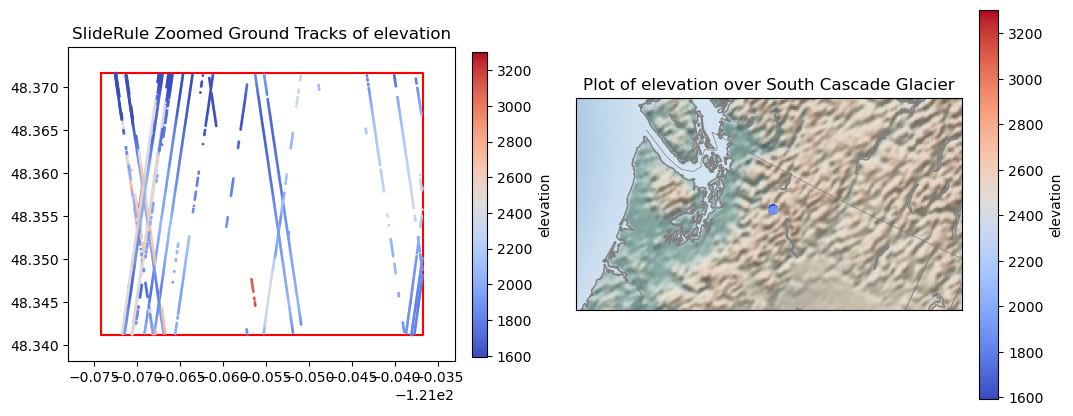

<Figure size 640x480 with 0 Axes>

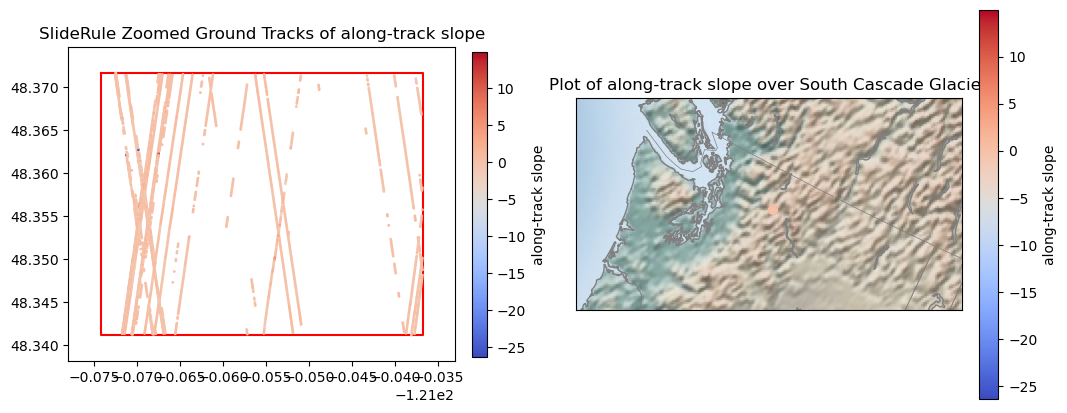

<Figure size 640x480 with 0 Axes>

In [6]:
# Request ATL06 Data
gdf = icesat2.atl06p(parms_alt)

var_name="h_mean"
var_label='elevation'
plot_variables(var_name, var_label,region_name,region,gdf)

var_name="dh_fit_dx"
var_label='along-track slope'
plot_variables(var_name, var_label,region_name,region,gdf)




## ATL08

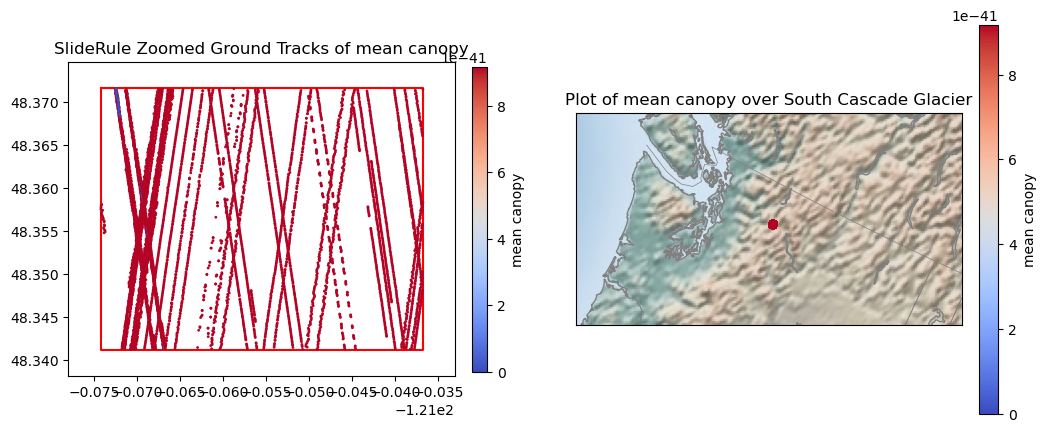

<Figure size 640x480 with 0 Axes>

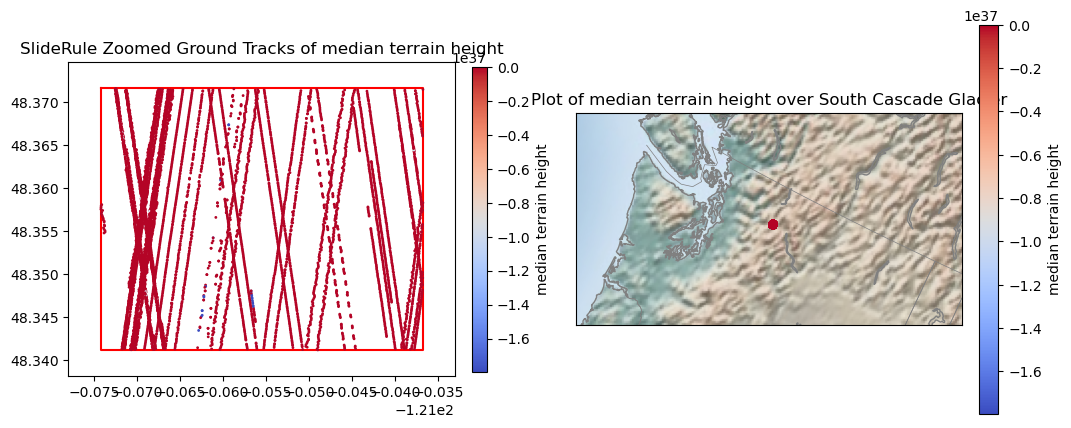

<Figure size 640x480 with 0 Axes>

In [7]:
# # Request ATL08 Data
parms_alt08 = {
    "poly": region,
    "srt": 0,#srt=0 (land)
    "cnf": 0,#cnf=0 (no native filtering)
    "ats": 10.0,
    "cnt": 0,
    "len": 40.0,
    "res": 20.0
}

gdf_ATL08= icesat2.atl08p(parms_alt08)

var_name="h_mean_canopy"
var_label='mean canopy'
plot_variables(var_name, var_label,region_name,region,gdf_ATL08)

var_name="h_te_median"
var_label='median terrain height'
plot_variables(var_name, var_label,region_name,region,gdf_ATL08)

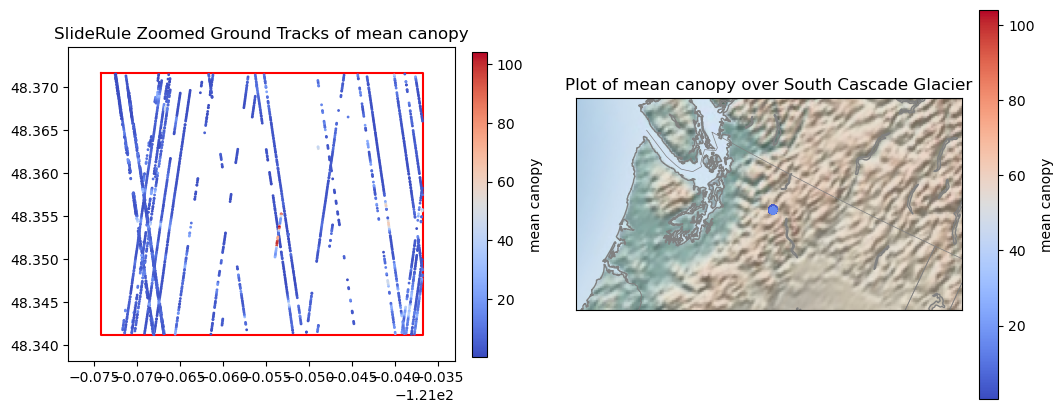

<Figure size 640x480 with 0 Axes>

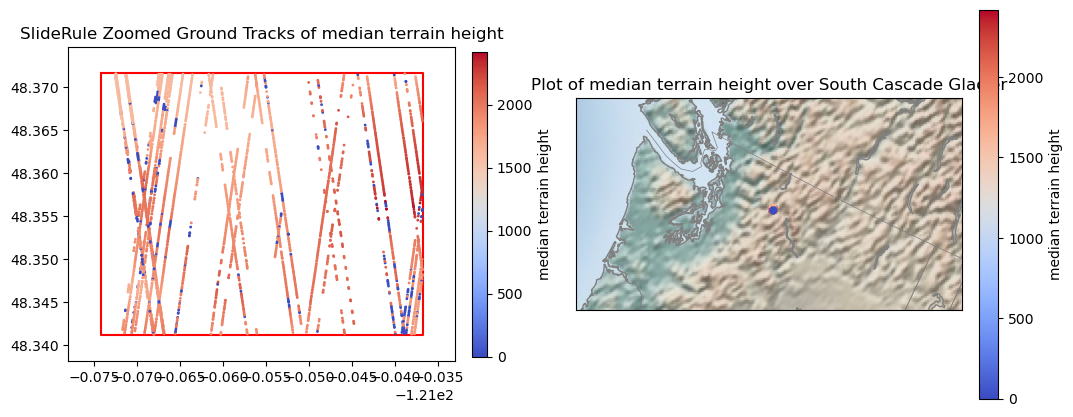

<Figure size 640x480 with 0 Axes>

In [8]:
# Request ATL08 Data
parms_alt081 ={"asset": "icesat2",
        "phoreal": {},
        "srt": -1,#0
        "poly":region}
gdf_ATL081= icesat2.atl08p(parms_alt081)
gdf_ATL081

var_name="h_mean_canopy"
var_label='mean canopy'
plot_variables(var_name, var_label,region_name,region,gdf_ATL081)

var_name="h_te_median"
var_label='median terrain height'
plot_variables(var_name, var_label,region_name,region,gdf_ATL081)

# GEDI

In [9]:
## GEDI
gedi.init("slideruleearth.io")
parms_gedi = { "poly": region }
# rsps = gedi.gedi04ap(parms_gedi)
rsps = gedi.gedi02ap(parms_gedi)

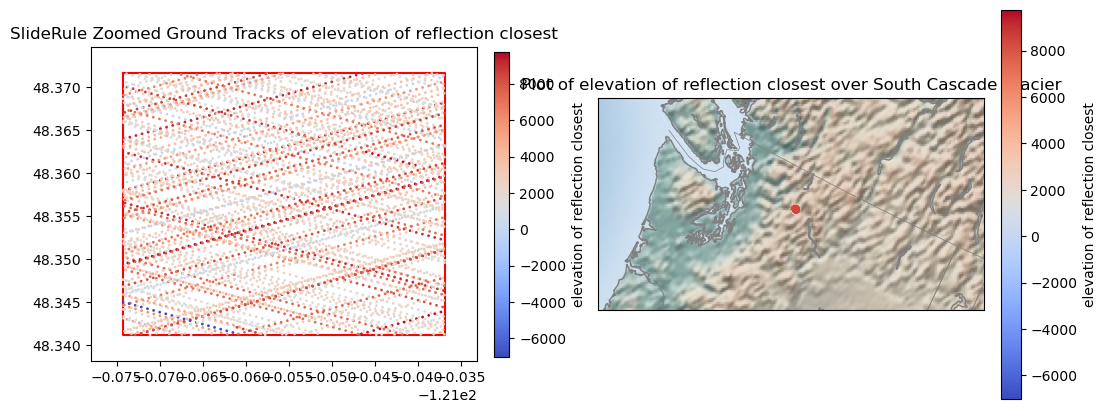

<Figure size 640x480 with 0 Axes>

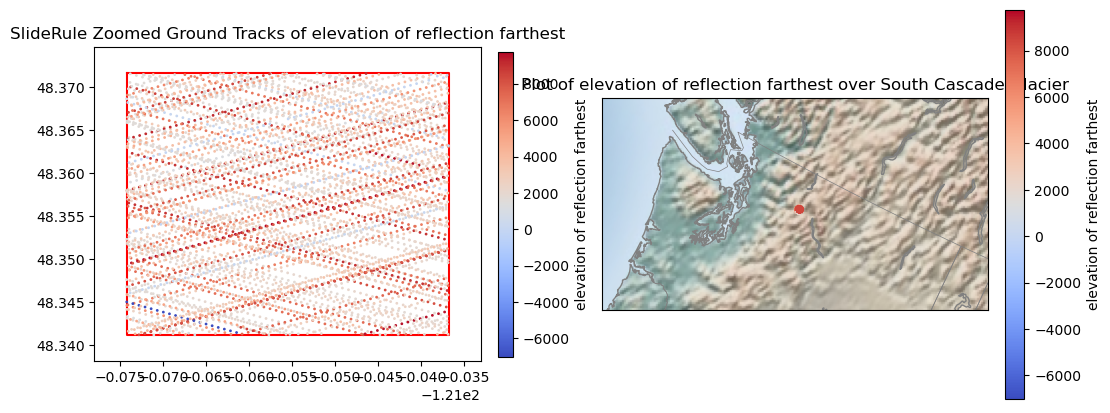

<Figure size 640x480 with 0 Axes>

In [10]:
var_name="elevation_lm"
var_label='elevation of reflection closest'
plot_variables(var_name, var_label,region_name,region,rsps)

var_name="elevation_hr"
var_label='elevation of reflection farthest'
plot_variables(var_name, var_label,region_name,region,rsps)